In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
np.random.seed(0)

In [39]:
def _r_CP(R_P,mu):
    """
    vector between C (joint) and P (parafoil COM, canopy mid baseline point)
    R_P: distance from C to P
    mu: rigging angle
    """
    return np.array([-R_P * np.sin(mu), 0, -R_P * np.cos(mu)])

def _r_CB(R_B):
    """
    vector between C (joint) and B (payload COM)
    R_B: distance from C to B
    """
    return np.array([0, 0, R_B])

In [40]:
def _skew_symmetric(vector):
    """generate skew symmetric matrix from a 3D vector"""
    p,q,r = tuple(vector)
    return np.array([
        [0, -r, q],
        [r, 0, -p],
        [-q, p, 0],
    ])

In [41]:
def _S_r_CP(R_P,mu):
    """
    r_CP in skew symmetric matrix form
    R_P: distance from C to P
    mu: rigging angle
    """
    return _skew_symmetric(_r_CP(R_P, mu))

def _S_r_CB(R_B):
    """
    r_CB in skew symmetric matrix form
    R_B: distance from C to B
    """
    return _skew_symmetric(_r_CB(R_B))

In [88]:
def _I_B(W, H, D, m_B):
    """
    payload inertia matrix
    W: payload width
    H: payload height
    D: payload depth
    m_B: payload mass
    """
    return m_B/12 * np.diag([W**2 + H**2, D**2 + H**2, D**2 + W**2])

def _I_P(I_xx, I_xz, I_yy, I_zx, I_zz):
    """
    parafoil inertia matrix
    """
    return np.array([
        [I_xx, 0, I_xz],
        [0, I_yy, 0],
        [I_zx, 0, I_zz],
    ])

def _I_F(rho, a, b, c, t):
    """
    apparent inertia matrix
    rho: density
    a: arc
    b: span
    c: chord
    t: thickness
    """
    AR = b/c #aspect ratio
    a_star = a/b #arc-to-span ratio
    t_star = t/c #relative thickness
    I_A = 0.055 * rho * AR/(1 + AR) * c**2 * b**3
    I_B = 0.0308 * rho * AR/(1 + AR) * (1 + np.pi/6 * (1 + AR) * AR * a_star**2 * t_star**2 ) * c**4 * b
    I_C = 0.0555 * rho * (1 + 8 * a_star**2) * t**2 * b**3
    return np.diag([I_A, I_B, I_C])

In [89]:
def _M_B(m_B):
    """
    payload mass matrix
    m_B: payload mass
    """
    return m_B * np.eye(3)

def _M_P(m_P, m_added):
    """
    parafoil mass matrix:
    m_P: parafoil mass
    m_added: added mass of air inflating the canopy?
    """
    return (m_P + m_added) * np.eye(3)

def _M_F(rho, a, b, c, t):
    """
    apparent mass matrix
    rho: density
    a: arc
    b: span
    c: chord
    t: thickness
    """
    AR = b/c #aspect ratio
    a_star = a/b #arc-to-span ratio
    t_star = t/c #relative thickness

    A = 0.666 * rho * (1 + 8/3 * a_star**2) * t**2 * b
    B = 0.267 * rho * (1 + 2 * a_star**2 / t_star**2 * AR**2 * (1 - t_star**2) ) * t**2 * c
    C = 0.785 * rho * np.sqrt(1 + 2 * a_star**2 * (1 - t_star**2)) * AR/(1+AR) * c**2 * b
    return np.diag([A, B, C])

In [90]:
def _T(phi, theta, psi):
    """
    rotation matrix
    """
    s_phi = np.sin(phi)
    c_phi = np.cos(phi)
    s_theta = np.sin(theta)
    c_theta = np.cos(theta)
    s_psi = np.sin(psi)
    c_psi = np.cos(psi)

    return np.array([
        [c_psi * c_theta, s_psi * c_theta, -s_theta],
        [c_psi * s_theta * s_phi - s_psi * c_phi, s_psi * s_theta * s_phi + c_psi * c_phi, c_theta * s_phi],
        [c_psi * s_theta * c_phi + s_psi * s_phi, s_psi * s_theta * c_phi - c_psi * s_phi, c_theta * c_phi],
    ])

In [91]:
def _F_gP(m_P, phi_P, theta_P):
    """
    weight force on parafoil
    m_P: parafoil mass
    theta_P, phi_P are wrt parafoil
    """
    return m_P * np.array([-np.sin(theta_P), np.cos(theta_P) * np.sin(phi_P), np.cos(theta_P) * np.cos(phi_P)])

def _F_gB(m_B, phi_B, theta_B):
    """
    weight force on payload
    m_B: payload mass
    theta_B, phi_B are wrt payload
    """
    return m_B * np.array([-np.sin(theta_B), np.cos(theta_B) * np.sin(phi_B), np.cos(theta_B) * np.cos(phi_B)])

In [147]:
def _M_g_P(S_r_CP, F_gP):
    """
    moment of parafoil due to gravity
    """
    return S_r_CP @ F_gP

def _M_g_B(S_r_CB, F_gB):
    """
    moment of payload due to gravity
    """
    return S_r_CB @ F_gB

In [148]:
def _F_b_P(m_added, phi_P, theta_P, g= 9.81):
    """
    buoyancy force on parafoil
    m_added: added mass
    g: gravitational constant
    theta_P, phi_P: angles of parafoil
    """
    return -m_added * g * np.array([-np.sin(theta_P), np.cos(theta_P) * np.sin(phi_P), np.cos(theta_P) * np.cos(phi_P)])

def _M_b_P(S_r_CP, F_b_P):
    """
    buoyancy moment on parafoil
    """
    return S_r_CP @ F_b_P

In [149]:
def _Omega_P(p_P, q_P, r_P):
    """
    parafoil angular velocity p_P, q_P, r_P in skew symmetric form
    """
    return _skew_symmetric(np.array([p_P, q_P, r_P]))

def _Omega_B(p_B, q_B, r_B):
    """
    payload angular velocity p_B, q_B, r_B in skew symmetric form
    """
    return _skew_symmetric(np.array([p_B, q_B, r_B]))

In [150]:
def _V_P(u_C, v_C, w_C, r_CP, T_P, Omega_P):
    """
    parafoil airspeed vector (u_P, v_P, w_P)
    T_P: T(phi_P, theta_P, psi_P)
    """
    return T_P @ np.array([u_C, v_C, w_C]) + Omega_P @ r_CP

def _V_B(u_C, v_C, w_C, r_CB, T_B, Omega_B):
    """
    parafoil airspeed vector (u_B, v_B, w_B)
    T_B: T(phi_B, theta_B, psi_B)
    """
    return T_B @ np.array([u_C, v_C, w_C]) + Omega_B @ r_CB

In [151]:
def _alpha(u_P, w_P):
    """
    angle of attack
    u_P: x component of parafoil airspeed
    w_P: z component of parafoil airspeed
    """
    return np.arctan2(w_P, u_P)

def _beta(u_P, v_P, w_P):
    """
    angle of side slip
    u_P, v_P, w_P are the 3 components of parafoil airspeed
    """
    return np.arctan2(v_P, np.sqrt(u_P**2 + w_P**2))

In [152]:
def _C_D(alpha, delta_s, C_D0, C_Dalpha2, C_Ddelta_s):
    """
    drag coefficient
    alpha: angle of attack
    delta_s: symmetric deflection
    C_D0: base value
    C_Dalpha2: scaling factor for angular of attack squared
    C_Ddelta_s: scaling factor for symmetric deflection
    """
    return C_D0 + C_Dalpha2 * alpha**2 + C_Ddelta_s * delta_s

def _C_Y(beta, C_Ybeta):
    """
    C_Ybeta: scaling factor
    beta: sideslip angle
    """
    return C_Ybeta * beta

def _C_L(alpha, delta_s, C_L0, C_Lalpha, C_Ldelta_s):
    """
    lift coefficient
    alpha: angle of attack
    delta_s: symmetric deflection
    C_L0: base value
    C_Lalpha: contribution of angle of attack
    C_Ldelta_s: contribution of symmetric deflection
    """
    return C_L0 + C_Lalpha * alpha + C_Ldelta_s * delta_s

def _C_X(u_P, w_P, C_D, C_L, V_P):
    return (-C_D * u_P + C_L * w_P)/V_P

def _C_Z(u_P, w_P, C_D, C_L, V_P):
    return (-C_D * w_P - C_L * u_P)/V_P

def _C_l(beta, p_P, r_P, delta_a, b, V_P, C_lbeta, C_lp, C_lr, C_ldelta_a):
    """
    b is span
    """
    return C_lbeta * beta + b/(2*V_P) * C_lp * p_P + b/(2*V_P) * C_lr * r_P + C_ldelta_a * delta_a

def _C_m(alpha, q_P, V_P, c, C_m0, C_malpha, C_mq):
    """
    c is chord
    """
    return C_m0 + C_malpha * alpha + c/(2*V_P) * C_mq * q_P

def _C_n(beta, p_P, r_P, delta_a, b, V_P, C_nbeta, C_np, C_nr, C_ndelta_a):
    """
    b is span
    """
    return C_nbeta * beta + b/(2*V_P) * C_np * p_P + b/(2*V_P) * C_nr * r_P + C_ndelta_a * delta_a


In [153]:
def _F_aP(rho, V_P, S, C_X, C_Y, C_Z):
    """
    aerodynamic force of parafoil
    """
    return 1/2 * rho * V_P**2 * S * np.array([C_X, C_Y, C_Z])

def _F_aB(u_B, v_B, w_B, rho, V_B, S_B, C_D_B):
    """
    aerodynamic force of payload
    """
    return 1/2 * rho * V_B * S_B * C_D_B * np.array([u_B, v_B, w_B])



In [154]:
def _M_aP(rho, b, c, V_P, S, x_pa, C_l, C_m, C_n, C_z):
    """
    x_pa: distance from parafoil center of pass to parafoil aerodynamic center
    """
    return 1/2 * rho * V_P**2 * S * np.array([b * C_l, c*C_m + x_pa * C_z, b*C_n])

In [155]:
def _angular_frame_change(phi, theta):
    """frame change matrix for angular velocity matrix"""
    return np.array([
        [1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],
        [0, np.cos(phi), -np.sin(phi)],
        [0, np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)],
    ])

In [172]:
def dynamics(time, states, **kwargs):
    p_B, q_B, r_B, p_P, q_P, r_P, u_C, v_C, w_C, f_Cx, f_Cy, f_Cz, x_C, y_C, z_C, phi_B, theta_B, psi_B, phi_P, theta_P, psi_P = tuple(states)
    V_C = np.array([u_C, v_C, w_C])
    M_B = _M_B(kwargs['m_B'])
    S_r_CB = _S_r_CB(kwargs['R_B'])
    T_B = _T(phi_B, theta_B, psi_B)
    M_P = _M_P(kwargs['m_P'], kwargs['m_added'])
    M_F = _M_F(kwargs['rho'], kwargs['a'], kwargs['b'], kwargs['c'], kwargs['t'])
    S_r_CP = _S_r_CP(kwargs['R_P'], kwargs['mu'])
    T_P = _T(phi_P, theta_P, psi_P)
    I_B = _I_B(kwargs['W'], kwargs['H'], kwargs['D'], kwargs['m_B'])
    I_P = _I_P(kwargs['I_xx'], kwargs['I_xz'], kwargs['I_yy'], kwargs['I_zx'], kwargs['I_zz'])
    I_F = _I_F(kwargs['rho'], kwargs['a'], kwargs['b'], kwargs['c'], kwargs['t'])
    O_3x3 = np.zeros((3,3))
    I_3x3 = np.ones((3,3))
    r_CB = _r_CB(kwargs['R_B'])
    r_CP = _r_CP(kwargs['R_P'], kwargs['mu'])
    
    Omega_B = _Omega_B(p_B, q_B, r_B)
    omega_B = np.array([p_B, q_B, r_B])
    u_B, v_B, w_B = tuple(_V_B(u_C, v_C, w_C, r_CB, T_B, Omega_B))
    V_B = np.linalg.norm(_V_B(u_C, v_C, w_C, r_CB, T_B, Omega_B))

    Omega_P = _Omega_P(p_P, q_P, r_P)
    omega_P = np.array([p_P, q_P, r_P])
    u_P, v_P, w_P = tuple(_V_P(u_C, v_C, w_C, r_CP, T_P, Omega_P))
    V_P = np.linalg.norm(_V_P(u_C, v_C, w_C, r_CP, T_P, Omega_P))

    alpha = _alpha(u_P, w_P)
    beta = _beta(u_P, v_P, w_P)
    
    C_D = _C_D(alpha, kwargs['delta_s'], kwargs['C_D0'], kwargs['C_Dalpha2'], kwargs['C_Ddelta_s'])
    C_L = _C_L(alpha, kwargs['delta_s'], kwargs['C_L0'], kwargs['C_Lalpha'], kwargs['C_Ldelta_s'])
    C_X = _C_X(u_P, w_P, C_D, C_L, V_P)
    C_Y = _C_Y(beta, kwargs['C_Ybeta'])
    C_Z = _C_Z(u_P, w_P, C_D, C_L, V_P)
    C_l = _C_l(beta, p_P, r_P, kwargs['delta_a'], kwargs['b'], V_P, kwargs['C_lbeta'], kwargs['C_lp'], kwargs['C_lr'], kwargs['C_ldelta_a'])
    C_m = _C_m(alpha, q_P, V_P, kwargs['c'], kwargs['C_m0'], kwargs['C_malpha'], kwargs['C_mq'])
    C_n = _C_n(beta, p_P, r_P, kwargs['delta_a'], kwargs['b'], V_P, kwargs['C_nbeta'], kwargs['C_np'], kwargs['C_nr'], kwargs['C_ndelta_a'])
    

    F_aP = _F_aP(kwargs['rho'], V_P, kwargs['S'], C_X, C_Y, C_Z)
    F_aB = _F_aB(u_B, v_B, w_B, kwargs['rho'], V_B, kwargs['S_B'], kwargs['C_D_B'])

    M_aP = _M_aP(kwargs['rho'], kwargs['b'], kwargs['c'], V_P, kwargs['S'], kwargs['x_pa'], C_l, C_m, C_n, kwargs['C_z'])

    F_gB = _F_gB(kwargs['m_B'], phi_B, theta_B)
    F_gP = _F_gP(kwargs['m_P'], phi_P, theta_P)
    F_b_P = _F_b_P(kwargs['m_added'], phi_P, theta_P)

    M_g_B = _M_g_B(S_r_CB, F_gB)
    M_g_P = _M_g_P(S_r_CP, F_gP)
    M_b_P = _M_b_P(S_r_CP, F_b_P)

    E_P = _angular_frame_change(phi_P, theta_P)
    E_B = _angular_frame_change(phi_B, theta_B)

    B0 = np.block([
        [-M_B @ S_r_CB, O_3x3, M_B @ T_B, T_B],
        [O_3x3, -(M_P + M_F)@S_r_CP, (M_P+M_F)@T_P, -T_P],
        [I_B, O_3x3, O_3x3, -S_r_CB @ T_B],
        [O_3x3, I_P+I_F, O_3x3, S_r_CP @ T_P],
    ])
    B0_extended = np.block([
        [B0, np.zeros((12,9))],
        [np.zeros((9,12)), np.eye(9)]
    ])


    B1 = F_aB + F_gB - Omega_B @ M_B @ Omega_B @ r_CB
    B2 = F_aP + F_gP + F_b_P - Omega_P @ (M_P + M_F) @ Omega_P @ r_CP + M_F @ Omega_P @ T_P @ V_C - Omega_P @ M_F @ T_P @ V_C
    B3 = M_g_B - Omega_B @ I_B @ omega_B
    B4 = M_aP + M_g_P + M_b_P - Omega_P @ I_P @ omega_P


    B5 = np.concatenate((B1, B2, B3, B4, np.array([u_C, v_C, w_C]), E_B @ omega_B, E_P @ omega_P))
    return np.linalg.inv(B0_extended) @ B5

In [173]:
S = 3.14
m_B = 200
R_B = 0.31
R_P = 1.24
m_P = 1.4
m_added = 0
x_pa = 0.26
rho = 5.43
a = 0.164
b = 3.07
c = 1.02
t = 0.075
mu = -12*np.pi/180
W = 0.5
H = 0.5
D = 0.5
I_xx = 1.0107
I_yy = 0.1427
I_zz = 1.1384
I_zx = 0.0284
I_xz = 0.0284
C_D_B = 0.4
S_B = 0.25

C_D0 = 0.25
C_L0 = 0.091
C_Dalpha2 = 0.12
C_Lalpha = 0.9
C_Ybeta = -0.23
C_Ddelta_s = 0.1
C_Ldelta_s = 0.15

C_lbeta = -0.0036
C_lp = -0.84
C_lr = -0.082
C_ldelta_a = -0.0035
C_m0 = 0.35
C_z = 0.1
C_malpha = -0.72
C_mq = -1.49
C_nbeta = -0.0015
C_ndelta_a = 0.0115
C_np = -0.082
C_nr = -0.27

delta_s=0
delta_a=0

In [174]:
def ode(time, states):
    return dynamics(time, states, S=S, m_B=m_B, R_B=R_B, R_P=R_P, m_P=m_P, 
            m_added=m_added, x_pa=x_pa, rho=rho, a=a, b=b, c=c, t=t, mu=mu, W=W, H=H, D=D, I_xx=I_xx,
            I_yy=I_yy, I_zz=I_zz, I_zx=I_zx, I_xz=I_xz, C_D_B=C_D_B, S_B=S_B, C_D0=C_D0, C_L0=C_L0, C_Dalpha2=C_Dalpha2,
            C_Lalpha=C_Lalpha, C_Ybeta=C_Ybeta, C_Ddelta_s=C_Ddelta_s, C_Ldelta_s=C_Ldelta_s, C_lbeta=C_lbeta, 
            C_lp=C_lp, C_lr=C_lr, C_ldelta_a=C_ldelta_a, C_m0=C_m0, C_z=C_z, C_malpha=C_malpha, C_mq=C_mq,
            C_ndelta_a=C_ndelta_a, C_nbeta=C_nbeta, C_np=C_np, C_nr=C_nr, delta_s=delta_s, delta_a=delta_a
            )

In [175]:
init_states = np.array([0,0,0,0,0,0,10,0,3,0,0,0,0,0,1000,0,0,0,0,0,0])
#p_B, q_B, r_B, p_P, q_P, r_P, u_C, v_C, w_C, f_Cx, f_Cy, f_Cz, x_C, y_C, z_C, phi_B, theta_B, psi_B, phi_P, theta_P, psi_P 
tspan = [0,90]
results = sp.integrate.solve_ivp(ode, tspan, init_states)

In [176]:
path = results.y[-6:-3,:]
print(path.shape)

(3, 398)


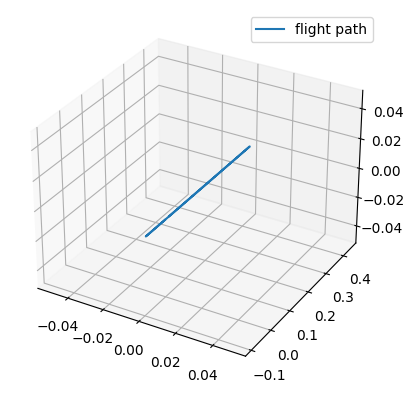

In [177]:
ax = plt.figure().add_subplot(projection='3d')

# Prepare arrays x, y, z
theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
x,y,z = path[0,:], path[1,:], path[2,:]


ax.plot(x, y, z, label='flight path')
ax.legend()

plt.show()

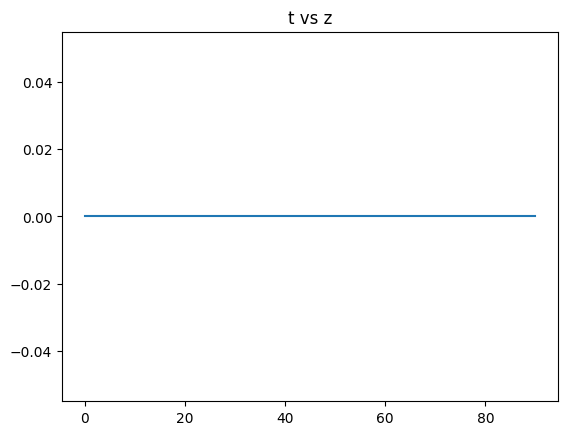

In [182]:
t = np.linspace(0,90,num = len(z))
plt.title("t vs z")
plt.plot(t,  z)
plt.show()